In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

import scipy.io as sio

from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(H0=70, Om0=0.3)
cosmo.age(1)

import seaborn as sns
import pandas as pd
from astropy.io import fits

sns.set(font_scale=2)
sns.set_style("whitegrid")

from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import axes3d

import statsmodels.api as sm
lowess = sm.nonparametric.lowess

In [2]:
warnings.filterwarnings('ignore')

candels_cat_z1 = np.loadtxt('catalogs/CANDELS_GDSS_workshop_z1.dat')

# subtracting 1 from the ID for python indexing
cat_z1_ids = candels_cat_z1[0:,0] - 1
cat_z1_z = candels_cat_z1[0:,1]

print(str(cat_z1_z.shape[0])+' galaxies in the z~1 catalog.')

ircat = np.genfromtxt('catalogs/CANDELS_GDSS_workshop_z1_fluxes_Jy_UVtoIR.dat')
print(ircat.shape)

# ID      zz                   1
# CTIO_U             eCTIO_U    3        
# VIMOS_U            eVIMOS_U    5       
# ACS_F435W          eACS_F435W   7      
# ACS_F606W          eACS_F606W    9     
# ACS_F775W          eACS_F775W     11    
# ACS_F814W          eACS_F814W      13   
# ACS_F850LP         eACS_F850LP       15 
# WFC3_F098M   eWFC3_F098M   17
# WFC3_F105W         eWFC3_F105W 19       
# WFC3_F125W         eWFC3_F125W   21     
# WFC3_F160W         eWFC3_F160W     23   
# ISAAC_KS           eISAAC_KS         25 
# HAWKI_KS           eHAWKI_KS          27
# IRAC_CH1           eIRAC_CH1          29
# IRAC_CH2           eIRAC_CH2          31
# IRAC_CH3           eIRAC_CH3          33
# IRAC_CH4           eIRAC_CH4          35
# f24            ef24           37
# f70            ef70           39
# f100           ef100          41
# f160           ef160          43
# f250           ef250          45
# flg1   flg2  47


371 galaxies in the z~1 catalog.
(371, 48)


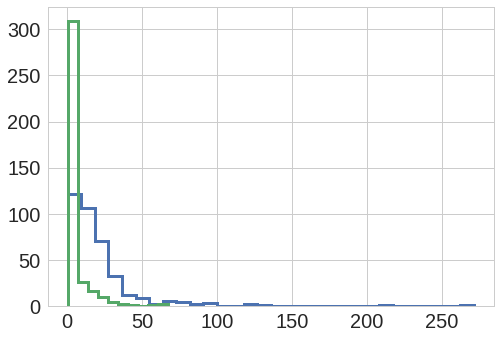

In [3]:
f435_snr = ircat[0:,6]/ircat[0:,7]
f24_snr = ircat[0:,36]/ircat[0:,37]
f100_snr = ircat[0:,40]/ircat[0:,41]
plt.hist(f435_snr,30,histtype='step',lw=3)
plt.hist(f24_snr,10,histtype='step',lw=3)
# plt.hist(f100_snr,50,histtype='step',lw=3)
plt.show()

In [4]:
thrs = 3
print(np.sum((f24_snr>thrs) & (f100_snr>thrs)))
print(np.sum((f24_snr>thrs)))
print(np.sum(f24_snr>0))

63
107
371


# Prospector - does not have an AGN fraction

# AGNFitter

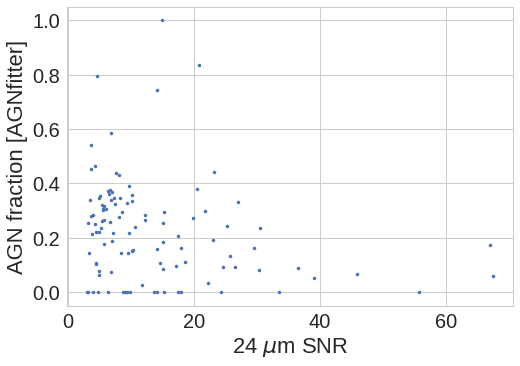

In [5]:
agnfitter_full = fits.open('code_outputs_IR/AGNfitter_CANDELS_z1sample.fits')

agnfitter_full[1].header

# internal IDs, aren't ordered by CANDELS ID

agnfitter_id = agnfitter_full[1].data['ID']
agnfitter_af = agnfitter_full[1].data['AGNfraction[1-10um]']

# matched to CANDELS ID array

agnfitter_ids = np.zeros((len(cat_z1_ids),))
agnfitter_agnfracs = np.zeros((len(cat_z1_ids),))

for i in range(369):

    temp = agnfitter_id[i]
    id_index = np.argmin(np.abs(temp - cat_z1_ids+1))
    agnfitter_ids[id_index] = temp
    agnfitter_agnfracs[id_index] = agnfitter_af[i]

plt.plot(f24_snr[(f24_snr>thrs)], agnfitter_agnfracs[(f24_snr>thrs)],'.')
plt.xlabel(r'24 $\mu$m SNR')
plt.ylabel('AGN fraction [AGNfitter]')
plt.show()

agnfitter_full.close()

# MAGPHYS

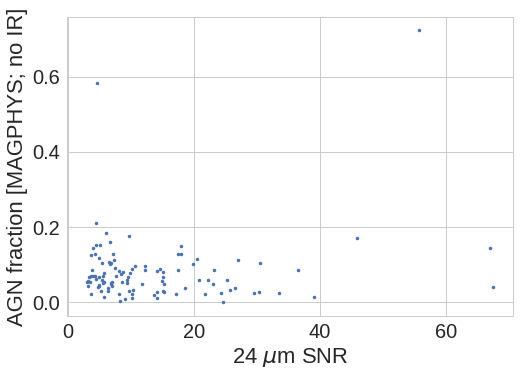

In [6]:
# without IR

magphys_cat = np.genfromtxt('code_outputs/magphys_output.dat')

# internal IDs, aren't ordered by CANDELS ID

magphys_id_full = magphys_cat[0:,0]
magphys_af = magphys_cat[0:,56]

# matched to CANDELS ID array

magphys_ids_z1 = np.zeros((len(cat_z1_ids),))
magphys_agnfracs_z1 = np.zeros((len(cat_z1_ids),))

for i in range(len(cat_z1_ids)):
    #print(len(magphys_id_full[magphys_id_full == candels_z1_ids[i]+1]))
    if len(magphys_id_full[magphys_id_full == cat_z1_ids[i]+1]) == 1:
        magphys_ids_z1[i] = magphys_id_full[magphys_id_full == cat_z1_ids[i]+1]

        magphys_agnfracs_z1[i] = magphys_af[magphys_id_full == cat_z1_ids[i]+1]
        
plt.plot(f24_snr[(f24_snr>thrs)], magphys_agnfracs_z1[(f24_snr>thrs)],'.')
plt.xlabel(r'24 $\mu$m SNR')
plt.ylabel('AGN fraction [MAGPHYS; no IR]')
plt.show()


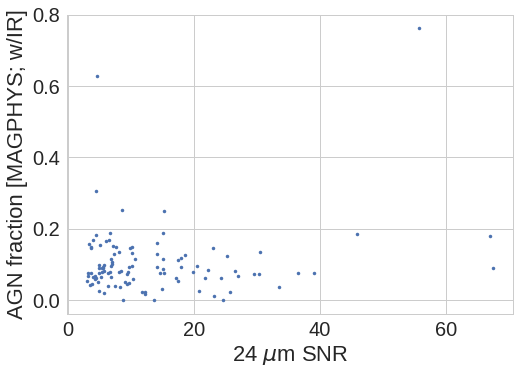

In [7]:
# with IR

magphys_IR_full = fits.open('code_outputs_IR/magphys_output_z1_ir.fits')
# magphys_IR_full.info()
# magphys_IR_full[1].header

# internal IDs, aren't ordered by CANDELS ID
magphys_IR_af = magphys_IR_full[1].data['agnf50_agn']

# matched to CANDELS ID array
magphys_ir_ids = np.zeros((len(cat_z1_ids),))
magphys_agnfracs_z1_IR = np.zeros((len(cat_z1_ids),))

for i in range(len(magphys_IR_full[1].data)):

    temp = magphys_IR_full[1].data[i][0]
    id_index = np.argmin(np.abs(cat_z1_ids - float(temp[0:-4])))

    magphys_ir_ids[id_index] = float(temp[0:-4])
    magphys_agnfracs_z1_IR[id_index] = magphys_IR_af[i]
    
magphys_IR_full.close()

      
plt.plot(f24_snr[(f24_snr>thrs)], magphys_agnfracs_z1_IR[(f24_snr>thrs)],'.')
plt.xlabel(r'24 $\mu$m SNR')
plt.ylabel('AGN fraction [MAGPHYS; w/IR]')
plt.show()


# SED3FIT

In [8]:

sed3fit_cat = np.genfromtxt('code_outputs_IR/RIVERSIDE_z1_NO_IR_SED3FIT_RESULTS_10_10.dat')
# print(sed3fit_cat.shape)

# ID
# tau_v16   tau_v50   tau_v84
# age_mw16   age_mw50   age_mw84
# Mstar16   Mstar50   Mstar84
# SFR16_7   SFR50_7   SFR84_7
# SFR16_8   SFR50_8   SFR84_8
# Av Av_std

sed3fit_mass = np.zeros((len(cat_z1_ids),))
sed3fit_sfr = np.zeros((len(cat_z1_ids),))
sed3fit_av = np.zeros((len(cat_z1_ids),))
sed3fit_agnfracs = np.zeros((len(cat_z1_ids),))

sed3fit_internal_id = sed3fit_cat[0:,0]
for i in range(len(sed3fit_internal_id)):
    id_index = np.argmin(np.abs(sed3fit_internal_id[i] - cat_z1_ids))
    sed3fit_mass[id_index] = sed3fit_cat[0:,8][i]
    sed3fit_sfr[id_index] = sed3fit_cat[0:,14][i] # update to SFR100 instead of SFR10
    sed3fit_av[id_index] = sed3fit_cat[0:,16][i]
    sed3fit_agnfracs[id_index] = sed3fit_cat[0:,18][i]


# plt.scatter(sed3fit_mass, sed3fit_sfr,c=sed3fit_av,cmap='magma')
# plt.show()

#sed3fit_ir_cat = np.genfromtxt('code_outputs_IR/RIVERSIDE_z1_IR_SED3FIT_RESULTS_8_2.dat')
sed3fit_cat = np.genfromtxt('code_outputs_IR/RIVERSIDE_z1_ONLY_IR_SED3FIT_RESULTS_10_10.dat')
# print(sed3fit_ir_cat.shape)


# sed3fit_ir_mass = sed3fit_ir_cat[0:,8]
# sed3fit_ir_sfr = sed3fit_ir_cat[0:,11]
# sed3fit_ir_av = sed3fit_ir_cat[0:,16]

sed3fit_ir_mass = np.zeros((len(cat_z1_ids),))
sed3fit_ir_sfr = np.zeros((len(cat_z1_ids),))
sed3fit_ir_av = np.zeros((len(cat_z1_ids),))
sed3fit_ir_agnfracs = np.zeros((len(cat_z1_ids),))

sed3fit_internal_id = sed3fit_cat[0:,0]
for i in range(len(sed3fit_internal_id)):
    id_index = np.argmin(np.abs(sed3fit_internal_id[i] - cat_z1_ids))
    sed3fit_ir_mass[id_index] = sed3fit_cat[0:,8][i]
    sed3fit_ir_sfr[id_index] = sed3fit_cat[0:,14][i] # update to SFR100 instead of SFR10
    sed3fit_ir_av[id_index] = sed3fit_cat[0:,16][i]
    sed3fit_ir_agnfracs[id_index] = sed3fit_cat[0:,18][i]



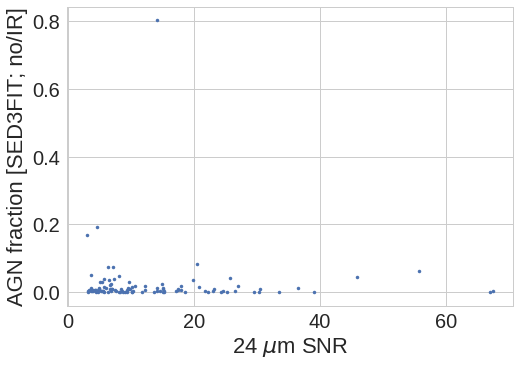

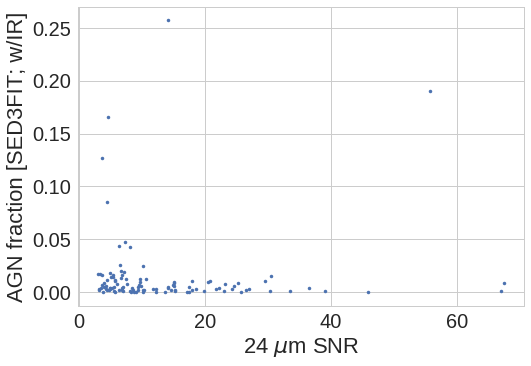

In [9]:

      
plt.plot(f24_snr[(f24_snr>thrs)], sed3fit_agnfracs[(f24_snr>thrs)],'.')
plt.xlabel(r'24 $\mu$m SNR')
plt.ylabel('AGN fraction [SED3FIT; no/IR]')
plt.show()


      
plt.plot(f24_snr[(f24_snr>thrs)], sed3fit_ir_agnfracs[(f24_snr>thrs)],'.')
plt.xlabel(r'24 $\mu$m SNR')
plt.ylabel('AGN fraction [SED3FIT; w/IR]')
plt.show()


# Bagpipes - does not have an AGN fraction

# CIGALE

In [10]:
c3 = fits.open('code_outputs_IR/cigale_agnf_withIR_withAGNs.fits')

c3[1].header

XTENSION= 'BINTABLE'           / binary table extension                         
BITPIX  =                    8 / 8-bit bytes                                    
NAXIS   =                    2 / 2-dimensional table                            
NAXIS1  =                   80 / width of table in bytes                        
NAXIS2  =                  371 / number of rows in table                        
PCOUNT  =                    0 / size of special data area                      
GCOUNT  =                    1 / one data group                                 
TFIELDS =                   10 / number of columns                              
EXTNAME = 'Joined  '           / table name                                     
TTYPE1  = 'id      '           / label for column 1                             
TFORM1  = 'K       '           / format for column 1                            
TTYPE2  = 'logMstar'           / label for column 2                             
TFORM2  = 'D       '        

In [11]:
cigale_id = c3[1].data['id']
cigale_agnfracs = c3[1].data['fracAGN']

c3.close()

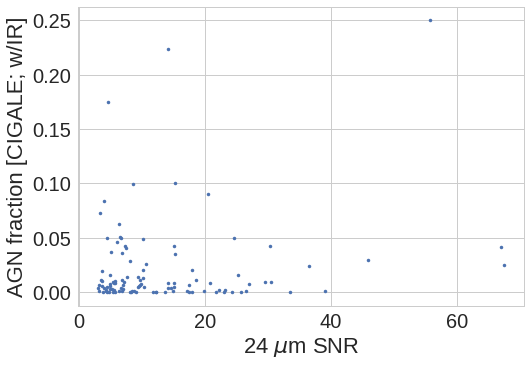

In [12]:
plt.plot(f24_snr[(f24_snr>thrs)], cigale_agnfracs[(f24_snr>thrs)],'.')
plt.xlabel(r'24 $\mu$m SNR')
plt.ylabel('AGN fraction [CIGALE; w/IR]')
plt.show()
